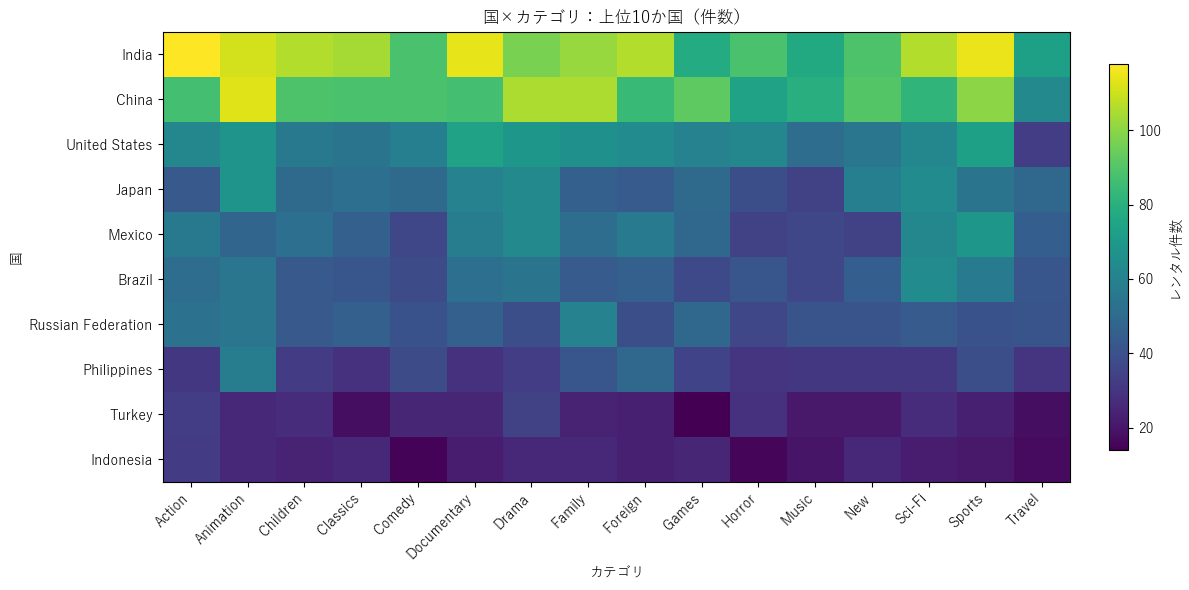

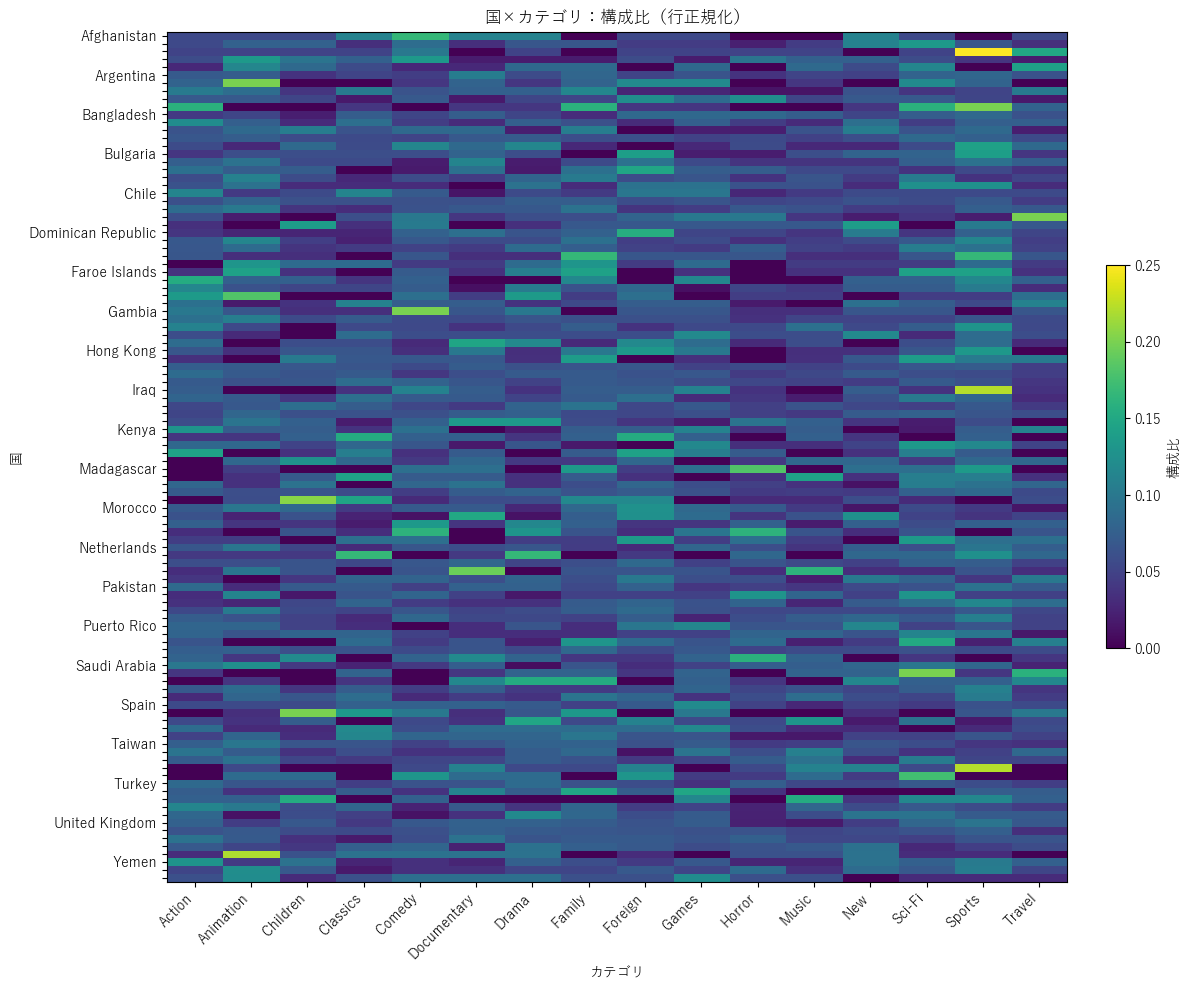

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams

def setup_japanese_font():
    """日本語フォント（文字化け防止）。見つかったものを優先設定。"""
    rcParams["axes.unicode_minus"] = False
    candidates = [
        "Yu Gothic", "Meiryo", "MS Gothic",            # Windows
        "Hiragino Sans", "Hiragino Kaku Gothic ProN",  # macOS
        "Noto Sans CJK JP", "IPAGothic", "IPAexGothic" # Linux
    ]
    installed = {f.name for f in fm.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            rcParams["font.family"] = name
            return name
    return None

def load_country_category_csv(csv_path="country_category_counts.csv"):
    """CSV 読み込み（行=国, 列=カテゴリ, 値=件数）"""
    df = pd.read_csv(csv_path, index_col=0)
    # 列・行の重複があれば落とす（保険）
    df = df.loc[:, ~df.columns.duplicated()]
    df = df[~df.index.duplicated(keep="first")]
    return df

def filter_top_countries(df, top_n=None):
    """総件数上位の国だけに間引き（top_nがNoneなら全件）"""
    if top_n is None:
        return df
    top_idx = df.sum(axis=1).nlargest(top_n).index
    return df.loc[top_idx]

def to_ratio(df, by="row"):
    """
    比率表へ変換。by="row" なら行内（国ごと）で正規化、by="col" なら列内（カテゴリごと）。
    """
    if by == "row":
        return df.div(df.sum(axis=1).replace(0, pd.NA), axis=0).fillna(0)
    elif by == "col":
        return df.div(df.sum(axis=0).replace(0, pd.NA), axis=1).fillna(0)
    else:
        raise ValueError('by must be "row" or "col"')

def plot_heatmap_from_table(df, title="国×カテゴリ：レンタル件数（ヒートマップ）",
                            figsize=(12, 8), y_step=None, cbar_label="値",
                            save_path=None):
    """
    df: 行=国, 列=カテゴリ の数値表
    y_step: 都市名が多い場合の間引き間隔（例: 5）。Noneなら間引きなし。
    """
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(df.values, aspect="auto")  # カラーマップは既定（必要なら変更可）

    # X軸（カテゴリ）
    ax.set_xticks(range(df.shape[1]))
    ax.set_xticklabels(df.columns, rotation=45, ha="right")

    # Y軸（国）—間引き表示
    ax.set_yticks(range(df.shape[0]))
    if y_step and y_step > 1:
        labels = [name if i % y_step == 0 else "" for i, name in enumerate(df.index)]
        ax.set_yticklabels(labels)
    else:
        ax.set_yticklabels(df.index)

    ax.set_xlabel("カテゴリ")
    ax.set_ylabel("国")
    ax.set_title(title)

    cbar = plt.colorbar(im, ax=ax, fraction=0.02, pad=0.04)
    cbar.set_label(cbar_label)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=200)
    plt.show()

if __name__ == "__main__":
    # 1) フォント（日本語対応）
    setup_japanese_font()

    # 2) CSV読み込み
    df = load_country_category_csv("country_category_counts.csv")

    # ==== 使い方例A：件数・上位10か国のみ・ラベル間引き ====
    df_top10 = filter_top_countries(df, top_n=10)
    plot_heatmap_from_table(
        df_top10,
        title="国×カテゴリ：上位10か国（件数）",
        figsize=(12, 6),
        y_step=None,              # 10件なら間引き不要、必要なら 2 など
        cbar_label="レンタル件数",
        save_path=None            # 例: "heatmap_country_counts_top10.png"
    )

    # ==== 使い方例B：比率（国ごとに構成比）・全ての国・ラベル間引き ====
    df_ratio = to_ratio(df, by="row")
    plot_heatmap_from_table(
        df_ratio,
        title="国×カテゴリ：構成比（行正規化）",
        figsize=(12, 10),
        y_step=5,                 # 5行ごとに国名を表示
        cbar_label="構成比",
        save_path=None            # 例: "heatmap_country_ratio.png"
    )
